<a href="https://colab.research.google.com/github/C10udburst/ml-playground/blob/master/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
  %tensorflow_version2.x
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
#!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.2


In [2]:
if tf.test.gpu_device_name():
  device = "/GPU:0"
else:
  device = "/CPU:0"
print(device)

/GPU:0


In [3]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-06-27 11:34:31--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.007s  

2022-06-27 11:34:31 (50.0 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-06-27 11:34:31--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [4]:
train_ds = pd.read_csv(train_file_path, sep='\t', header=None)
test_ds = pd.read_csv(test_file_path, sep='\t', header=None)

In [5]:
train_ds_len, test_ds_len = len(train_ds), len(test_ds)
ds = pd.concat([train_ds, test_ds])
ds[0] = pd.factorize(ds[0])[0]
train_ds, test_ds = ds.head(train_ds_len), ds.tail(test_ds_len)

In [6]:
train_ds.head()

,0,1
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


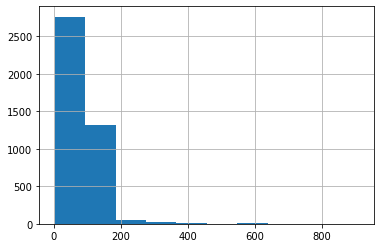

In [7]:
train_ds[1].apply(len).hist()

In [8]:
np.amax(train_ds[1].apply(len))

910

In [9]:
with tf.device(device):
  text_embedding = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True)
  text_embedding(["hello world"])

In [10]:
with tf.device(device):
  model = tf.keras.Sequential()
  model.add(text_embedding)
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
with tf.device(device):
  model.compile(optimizer='adam',
                loss=tf.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [12]:
with tf.device(device):
  history = model.fit(train_ds[1],
                      train_ds[0],
                      epochs=40,
                      batch_size=512,
                      validation_data=(test_ds[1], test_ds[0]),
                      callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)],
                      verbose=1)

Epoch 1/40
9/9 [==============================] - 6s 98ms/step - loss: 0.6461 - accuracy: 0.6956 - val_loss: 0.5879 - val_accuracy: 0.8182
Epoch 2/40
9/9 [==============================] - 0s 48ms/step - loss: 0.5434 - accuracy: 0.8567 - val_loss: 0.5049 - val_accuracy: 0.8642
Epoch 3/40
9/9 [==============================] - 0s 48ms/step - loss: 0.4630 - accuracy: 0.8744 - val_loss: 0.4370 - val_accuracy: 0.8721
Epoch 4/40
9/9 [==============================] - 0s 49ms/step - loss: 0.3958 - accuracy: 0.8825 - val_loss: 0.3794 - val_accuracy: 0.8807
Epoch 5/40
9/9 [==============================] - 0s 48ms/step - loss: 0.3372 - accuracy: 0.8938 - val_loss: 0.3296 - val_accuracy: 0.8901
Epoch 6/40
9/9 [==============================] - 0s 49ms/step - loss: 0.2864 - accuracy: 0.9095 - val_loss: 0.2865 - val_accuracy: 0.9052
Epoch 7/40
9/9 [==============================] - 0s 49ms/step - loss: 0.2424 - accuracy: 0.9325 - val_loss: 0.2491 - val_accuracy: 0.9203
Epoch 8/40
9/9 [===========

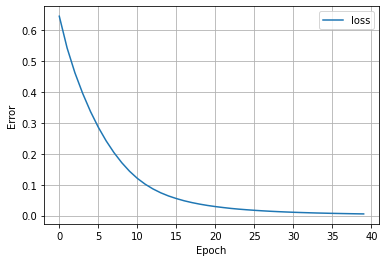

In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [14]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  prediction = model.predict([pred_text], verbose=2).item(0)
  res = [prediction]
  if prediction < 0.5:
    res.append('ham')
  else:
    res.append('spam')
  return res

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 - 0s - 85ms/epoch - 85ms/step
[-4.291407585144043, 'ham']


In [15]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
You passed the challenge. Great job!
